# Objective
To test different algorithms for edge segmentation, watermark removal using `opencv`

# Setup
## Load Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.catch_warnings()
warnings.simplefilter(action="ignore", category=FutureWarning)

In [55]:
import os
from typing import Union
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from skimage.feature import peak_local_max
from skimage.segmentation import watershed, find_boundaries
from skimage.filters import threshold_multiotsu
from skimage.morphology import remove_small_objects
from scipy import ndimage

parent_dir = os.path.dirname(os.path.abspath(os.path.curdir))


In [3]:
def display_image(
    image: np.ndarray,
    cmap: Union[bool, str] = False,
    ax=None
) -> None:
    draw = False
    if isinstance(cmap, bool) and cmap:
        cmap = "gray"
    elif not cmap:
        cmap = None
    if ax is None:
        draw = True
        _, ax = plt.subplots()
    ax.imshow(image, cmap=cmap)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.tick_params(
        axis="both",
        labelbottom=False,
        labelleft=False,
        width=0)
    if draw:
        plt.show()
    return None


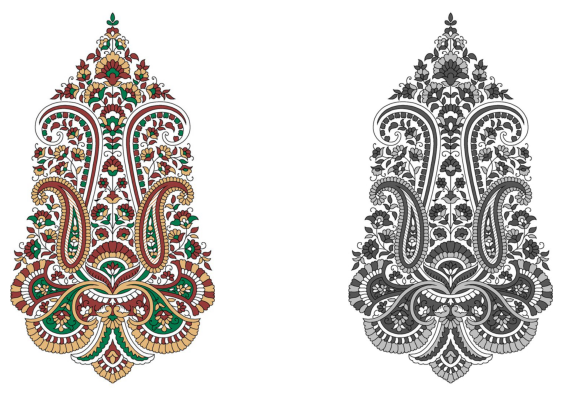

In [69]:
pln = 5
path = os.path.join(parent_dir, "tests", "test_data", f"Persian large {pln}.jpg")
im1 = cv2.imread(path)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
nm = f"PL{pln}"

# convert to grayscale and show
grayscale = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
_, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 5))
display_image(im1, ax=ax0)
display_image(grayscale, cmap=True, ax=ax1)
plt.show()


# Testing edge segmentation

## Default binarization

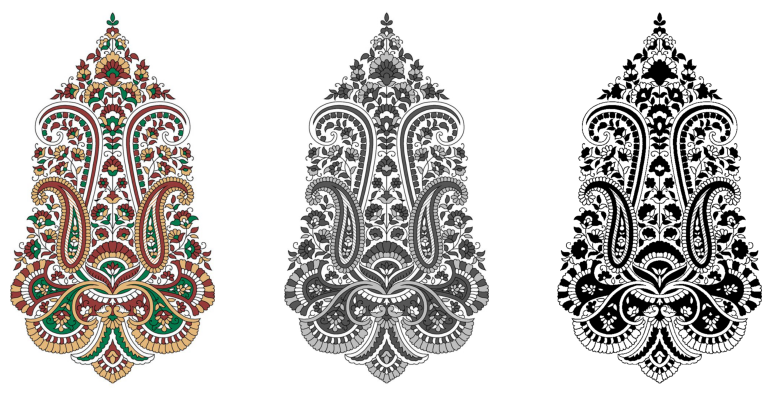

In [70]:
binary = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
_, axes = plt.subplots(ncols=3, figsize=(10, 5))
display_image(im1, ax=axes[0])
display_image(grayscale, ax=axes[1], cmap="gray")
display_image(binary, cmap="gray", ax=axes[-1])
plt.show()

C:\Users\Deepk\AppData\Local\Temp\ipykernel_13220\3980115344.py:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(


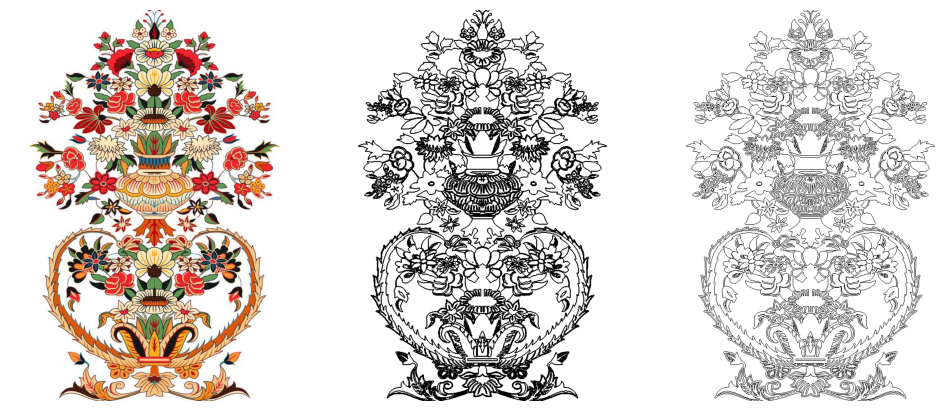

In [ ]:
distance_map = ndimage.distance_transform_edt(binary)
# md_list = [1, 10, 20, 50, 100, 120, 130, 150, 200]
md_list = [1]
for min_distance in md_list:
    local_max = peak_local_max(
        distance_map,
        labels=binary,
        min_distance=min_distance, indices=False)
    markers = ndimage.label(local_max)[0]
    labels = watershed(-distance_map, markers=markers, mask=binary)
    l_c = labels.copy()
    md = scipy.stats.mode(labels, axis=None, keepdims=False)[0]
    l_c[labels == md] = 0
    l_c[labels != md] = 1
    boundary_im = find_boundaries(l_c, mode="thick")
    _, axes = plt.subplots(ncols=3, figsize=(12, 8))
    display_image(im1, ax=axes[0])
    display_image(np.invert(boundary_im), ax=axes[1], cmap="gray")
    b2 = find_boundaries(l_c, mode="inner")
    display_image(~b2, ax=axes[-1], cmap="gray")
    plt.savefig(
        os.path.join(parent_dir, "tests", "test_results", f"{nm}_watershed_md{min_distance}.pdf"),
        transparent=True, bbox_inches="tight")
    plt.show()

## Multithresholding

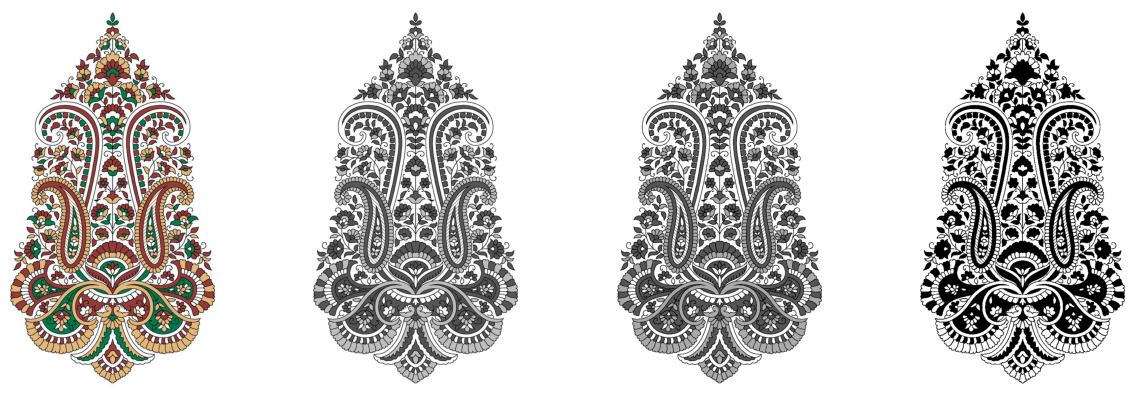

In [71]:
classes = 4
thresholds = threshold_multiotsu(grayscale, classes=classes)
regions = np.digitize(grayscale, bins=thresholds)
_, axes = plt.subplots(ncols=4, figsize=(15, 5))
display_image(im1, ax=axes[0])
display_image(grayscale, cmap="gray", ax=axes[1])
display_image(regions, cmap="gray", ax=axes[-2])
display_image(binary, cmap="gray", ax=axes[-1])
plt.show()

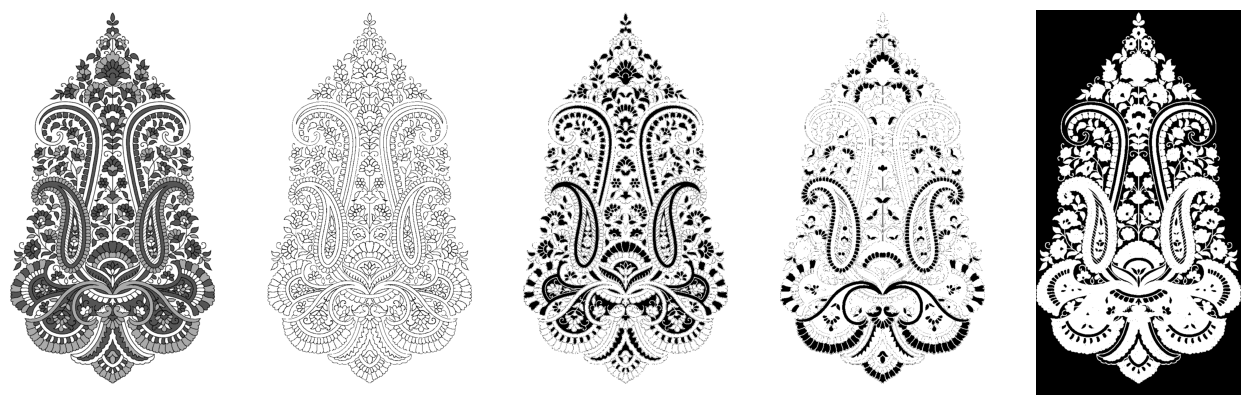

In [72]:
_, axes = plt.subplots(ncols=classes + 1, figsize=(4 * classes, 5))
display_image(regions, cmap="gray", ax=axes[0])
for k in np.unique(regions.ravel()):
    treg = np.zeros_like(regions, dtype="uint8")
    treg[regions != k] = 0
    treg[regions == k] = 1
    display_image(~treg, cmap="gray", ax=axes[k + 1])
plt.show()

### Watershed
For each binary, create a boundary map and take the `or` operation to combine all

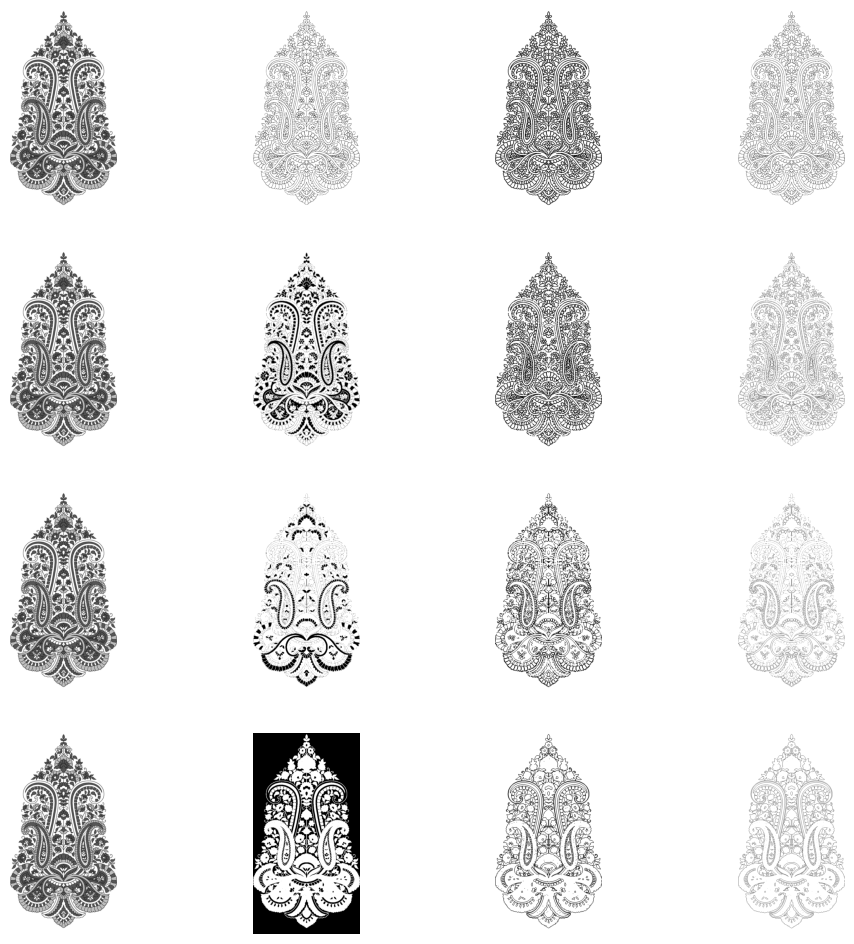

In [73]:
uregs = np.unique(regions.ravel())
b_thick: "list[np.ndarray]" = [None] * len(uregs)
b_inner: "list[np.ndarray]" = [None] * len(uregs)
_, axes = plt.subplots(nrows=len(uregs), ncols=4, figsize=(3 * len(uregs), 12))
for k in uregs:
    # binarize
    treg = np.zeros_like(regions, dtype="uint8")
    treg[regions != k] = 0
    treg[regions == k] = 1
    # watershed
    distance_map = ndimage.distance_transform_edt(treg)
    min_dist = 1
    local_max = peak_local_max(
        distance_map,
        min_distance=min_dist,
        indices=None,
        labels=treg)
    markers = ndimage.label(local_max)[0]
    labels = watershed(-distance_map, markers=markers, mask=treg)
    l_c = labels.copy()
    md = scipy.stats.mode(labels, axis=None, keepdims=False)[0]
    l_c[labels == md] = 0
    l_c[labels != md] = 1
    # retain both boundary images
    b_thick[k] = find_boundaries(l_c, mode="thick")
    b_inner[k] = find_boundaries(l_c, mode="inner")
    # plot comparisons
    display_image(grayscale, cmap="gray", ax=axes[k, 0])
    display_image(~treg, cmap="gray", ax=axes[k, 1])
    display_image(~b_thick[k], cmap="gray", ax=axes[k, 2])
    display_image(~b_inner[k], cmap="gray", ax=axes[k, 3])
plt.show()


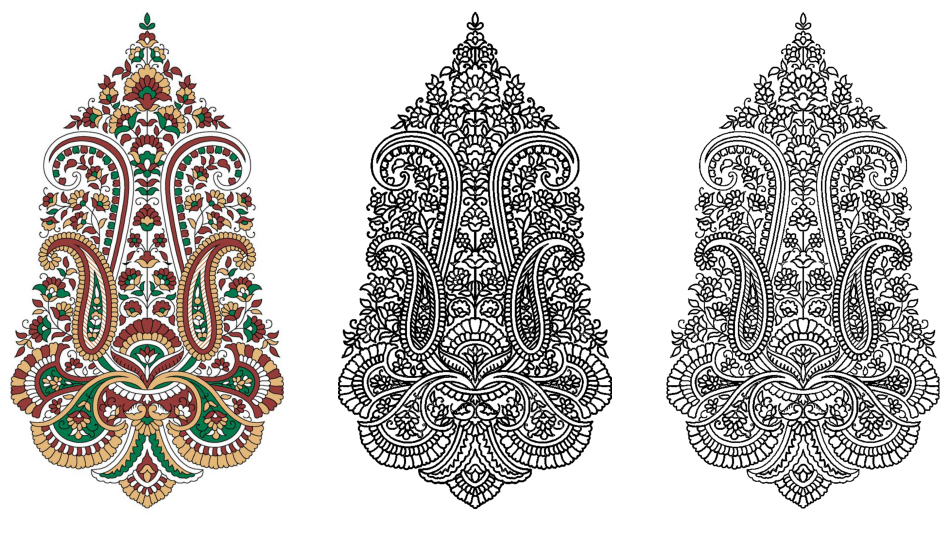

In [79]:
# now combine boundary images
_, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 7))
boundary_thick = np.apply_along_axis(
    np.any, axis=2, arr=np.array(b_thick)[:-1].transpose([1, 2, 0]))
boundary_inner = np.apply_along_axis(
    np.any, axis=2, arr=np.array(b_inner)[:-1].transpose([1, 2, 0]))
display_image(im1, ax=ax0)
display_image(~boundary_thick, cmap="gray", ax=ax1)
display_image(~boundary_inner, cmap="gray", ax=ax2)
plt.savefig(
    os.path.join(parent_dir, "tests", "test_results", f"{nm}_watershed_multiotsu.png"),
    bbox_inches="tight", pad_inches=0, dpi=300)
plt.show()